In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [1003]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.

save_folder = 'SGD-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

In [937]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [938]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    pi_c = torch.full((1,1,K_model_cluster),1./K_model_cluster).to(device)

    return mu_c,logvar_c,pi_c

    #mu_center = mus.mean(0,keepdim=True).detach().requires_grad_(False)
    #mus_white = mus.detach().requires_grad_(False)-mu_center
    #cov_mus = torch.matmul(mus_white.squeeze(2).t(),mus_white.squeeze(2))/mus.shape[0]

    #mu_distribution = MultivariateNormal(loc=mu_center.view(-1,latent_dim),covariance_matrix=cov_mus)
    #mu_c = mu_distribution.sample([K_model_cluster,])
    #mu_c = mu_c.permute(1,2,0)

    #logvar_c = torch.diag(cov_mus).log()
    #logvar_c = logvar_c.view(1,latent_dim,1)
    #logvar_c = logvar_c.repeat(1,1,K_model_cluster)

    #mu_distribution = MultivariateNormal(loc=torch.zeros(latent_dim),covariance_matrix=torch.eye(latent_dim))
    #mu_c = mu_distribution.sample([K_model_cluster,])
    #mu_c = mu_c.permute(1,0)
    #mu_c = mu_c.view(1,latent_dim,K_model_cluster).to(device)

In [939]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 20]), torch.Size([1, 10, 20]), torch.Size([1, 1, 20]))

In [940]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
pi_c_g.requires_grad_(False)

tensor([[[0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
          0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
          0.0500, 0.0500, 0.0500, 0.0500]]], device='cuda:0')

In [941]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,pi_c_g.requires_grad

(True, True, False)

In [942]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.StepLR(optimizer_clustering,step_size=10,gamma=0.9)


In [884]:
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,input_dim),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

    return BCE+beta*KLD



In [885]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))


In [886]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [887]:

def initial_train(epochs):
    for epoch in range(1, epochs +1):
        train(epoch)
        test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [888]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [889]:
def gauss(mus,logvars,mu_c,logvar_c,pi_c,iter):
    #mus = mus_ini
    #logvars = logvars_ini
    #mu_c = mu_c_ini
    #logvar_c = logvar_c_ini
    #pi_c = pi_c_ini

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P

In [890]:

def gauss_z(z,mu_c,logvar_c,pi_c,iter):
    #mus = mus_ini
    #logvars = logvars_ini
    #mu_c = mu_c_ini
    #logvar_c = logvar_c_ini
    #pi_c = pi_c_ini

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+((z-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)#+eps_N_c*torch.ones_like(gamma_c)
            log_P = (((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*z).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((z-mu_c).pow(2))).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P

In [900]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

In [892]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [893]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    #KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    #Q_c_f = -logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())
    #KLD = (((pi_c_f*((-0.5*(-logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())).sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()
    KLD = -0.5*(1+logvars_f).sum() -(((pi_c_f*((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [894]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,pi_c_f=pi_c_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [895]:
def test_c(epoch,mu_c,logvar_c,pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,pi_c_f=pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [896]:
def train_c_epoch(epochs,mu_c,logvar_c,pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,pi_c)
        test_c(epoch,mu_c,logvar_c,pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [897]:
mu_c_g,logvar_c_g,pi_c_g

(tensor([[[-1.3770,  0.1899, -1.6141, -0.2470,  0.4051, -1.4607, -0.2888,
           -0.5350,  1.1047,  1.0723, -1.2907,  0.6557, -0.4676,  0.8220,
           -0.2310],
          [-0.3067,  0.5231,  0.5989,  0.5619, -1.0392,  0.2726,  0.7544,
            0.5243, -1.0135, -0.2254, -2.1005, -1.3786, -1.4012, -1.3439,
           -0.6293],
          [-0.9324, -0.1368,  1.1153, -0.8567, -0.2944, -0.2325,  1.5845,
           -0.2529, -0.0926, -0.3284, -0.0783,  0.8460, -0.5668,  0.6722,
            0.3490],
          [ 0.0417,  0.4540, -1.2315,  0.1286, -0.0863, -1.8573, -0.3815,
           -0.3467, -0.2260,  1.2498,  0.5175,  0.0047, -1.0470,  0.1833,
           -1.4860],
          [-0.3376, -1.6903, -0.4795, -1.4233,  0.1834, -0.9634, -0.1833,
            1.2527,  0.4442,  0.3589,  0.5600,  0.0503, -0.3358, -0.6626,
           -0.5991],
          [ 1.5546,  0.4550,  1.0273, -1.0631, -0.8834,  1.5043,  1.4660,
            0.8585,  0.7218, -0.9582,  0.9544, -0.9928, -1.1527, -0.1265,
       

In [991]:
for i in range(100):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)
    scheduler.step()
    scheduler_clustering.step()


Train Epoch: 0 [0/60000 (0%)]	Loss: 95.167686
====> Test set loss: 1.1208
Train Epoch: 1 [0/60000 (0%)]	Loss: 94.296777
====> Test set loss: 1.0696
Train Epoch: 2 [0/60000 (0%)]	Loss: 94.407842
====> Test set loss: 1.0726
Train Epoch: 3 [0/60000 (0%)]	Loss: 94.317129
====> Test set loss: 1.0432
Train Epoch: 4 [0/60000 (0%)]	Loss: 94.609531
====> Test set loss: 1.0082
Train Epoch: 5 [0/60000 (0%)]	Loss: 96.524609
====> Test set loss: 1.0074
Train Epoch: 6 [0/60000 (0%)]	Loss: 94.414004
====> Test set loss: 0.9800
Train Epoch: 7 [0/60000 (0%)]	Loss: 97.941143
====> Test set loss: 1.0641
Train Epoch: 8 [0/60000 (0%)]	Loss: 96.099609
====> Test set loss: 1.0998
Train Epoch: 9 [0/60000 (0%)]	Loss: 98.706797
====> Test set loss: 1.1157
Train Epoch: 10 [0/60000 (0%)]	Loss: 94.997559
====> Test set loss: 1.0603
Train Epoch: 11 [0/60000 (0%)]	Loss: 95.777129
====> Test set loss: 1.0047
Train Epoch: 12 [0/60000 (0%)]	Loss: 91.243437
====> Test set loss: 1.0373
Train Epoch: 13 [0/60000 (0%)]	Loss

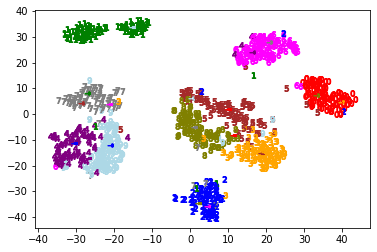

In [992]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,ts_g.cpu().detach().numpy())

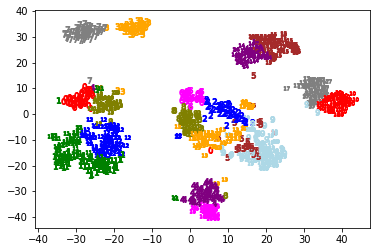

In [993]:

kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,kmeans_model.labels_)

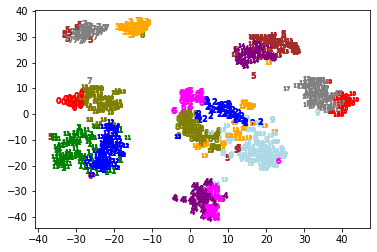

In [994]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))

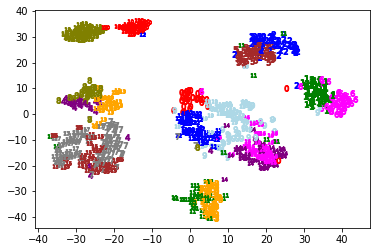

In [995]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,pi_c_g,1)
drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())

In [996]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [997]:
optimizer.param_groups[0]['lr']

8.478231655043248e-05

In [998]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [999]:
correspond_matrix

tensor([[ 0., 63.,  0.,  0.,  0.,  0., 41.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 45.,  2.,  1.,  1.,
          0.,  0.,  0.,  0., 58.,  0.],
        [ 0.,  0.,  0., 54.,  0.,  0.,  2.,  0.,  0.,  0.,  0., 29.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  4.,  1.,  1.,
         44.,  0., 41.,  0.,  0.,  1.],
        [ 0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  2.,
          0., 21.,  0., 65.,  0.,  0.],
        [25.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 16.,  0.,  0.,  0.,  0.,
          1.,  0.,  9.,  0.,  0., 51.],
        [ 0.,  0., 54.,  0.,  0., 55.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 25.,  0.,  0.,  0., 28.,  0.,  0.,  1.,  0., 27.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 9.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,

In [1000]:
correspond_matrix.sum()

tensor(1000.)

In [1001]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([25., 63., 54., 54., 25., 55., 41., 71., 28., 17., 45., 29., 68., 27.,
        44., 31., 41., 65., 58., 51.]),
indices=tensor([5, 0, 6, 2, 7, 6, 0, 9, 7, 8, 1, 2, 8, 7, 3, 9, 3, 4, 1, 5]))

In [1002]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.8920)